In [3]:
# Standard imports
import os, random, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv
import torchvision.transforms as T
from tqdm.auto import tqdm

# Optional libs
try:
    import torchattacks as ta
    HAS_TORCHATTACKS = True
except Exception:
    HAS_TORCHATTACKS = False
try:
    import faiss
    HAS_FAISS = True
except Exception:
    HAS_FAISS = False

print('torchattacks:', HAS_TORCHATTACKS, 'faiss:', HAS_FAISS)


torchattacks: True faiss: True


In [4]:
# === ra-cnn-custom.ipynb — Block 1: Setup & Datasets ===
# Paper mapping:
# - §5.1 Settings: datasets, augmentation only on D (train) not on D' (candidate set)
# - §2.3 Retrieval Engine: φ′(x) computed over D' (candidate set) without augmentation
# - §5.1 Evaluation metric: normalized L2 dissimilarity

import os, math, random, json, time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ----------------------------
# Reproducibility & device
# ----------------------------
SEED = 1234
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP = True  # mixed precision for speed on RTX 50xx / T4

# ----------------------------
# Paths & simple config
# ----------------------------
ROOT = Path(".").resolve()
# ✅ changed: use shared root-level data folder so both notebooks reuse same CIFAR-10
DATA_DIR = ROOT.parent / "data"

ARTIFACTS = ROOT / "artifacts"
CHECKPOINTS = ROOT / "checkpoints"
RESULTS = ROOT / "results"
FIGS = ROOT / "figures"


for p in [ARTIFACTS, CHECKPOINTS, RESULTS, FIGS]:
    p.mkdir(parents=True, exist_ok=True)

CONFIG = {
    "seed": SEED,
    "device": str(DEVICE),
    "amp": AMP,
    "baseline": {"epochs": 40, "min_epochs": 20, "early_patience": 8, "batch_size": 128, "lr": 1e-3, "wd": 5e-4},
    "racnn":    {"epochs": 30, "min_epochs": 15, "early_patience": 6, "batch_size": 128, "lr": 1e-3, "wd": 5e-4},
    "K_values": [5, 10],
    "mixup": {"NMU": 5, "NCE": 1},
    "eps_grid_l2": [1e-5, 2e-5, 8e-5, 1e-4, 2e-4, 4e-4],
    "pgd": {"steps": 10, "rand_start": True}
}

with open(ROOT / "config.json", "w") as f:
    json.dump(CONFIG, f, indent=2)

# ----------------------------
# CIFAR-10 normalization
# ----------------------------
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# ----------------------------
# Transforms
# ----------------------------
train_transform_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

plain_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# ----------------------------
# Datasets
# ----------------------------
# ✅ changed: set download=False everywhere because dataset already exists
train_aug_ds   = datasets.CIFAR10(root=DATA_DIR, train=True,  download=True, transform=train_transform_aug)
train_plain_ds = datasets.CIFAR10(root=DATA_DIR, train=True,  download=True, transform=plain_transform)
test_ds        = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=plain_transform)

# ----------------------------
# Loaders
# ----------------------------
BATCH_TRAIN = CONFIG["baseline"]["batch_size"]
BATCH_EVAL  = 256

train_aug_loader   = DataLoader(train_aug_ds,   batch_size=BATCH_TRAIN, shuffle=True,  num_workers=4, pin_memory=True)
train_plain_loader = DataLoader(train_plain_ds, batch_size=BATCH_EVAL,  shuffle=False, num_workers=4, pin_memory=True)
test_loader        = DataLoader(test_ds,        batch_size=BATCH_EVAL,  shuffle=False, num_workers=4, pin_memory=True)

# === Fixed Normalized L2 Dissimilarity (Paper §5.1) ===

def normalized_l2(x, x_adv):
    """
    Paper §5.1 metric:
      L2_norm(x, x_adv)² / (dim(x))
    
    For CIFAR-10: pixels are in [0,1] after denormalization,
    so (max-min)² = 1² = 1
    
    Args:
        x: normalized tensor [B, C, H, W]
        x_adv: normalized adversarial tensor [B, C, H, W]
    
    Returns:
        normalized L2 distance per sample [B]
    """
    # Denormalize to [0, 1] range
    mean = torch.tensor(CIFAR10_MEAN, device=x.device).view(1, 3, 1, 1)
    std = torch.tensor(CIFAR10_STD, device=x.device).view(1, 3, 1, 1)
    
    x_raw = (x * std + mean).clamp(0, 1)
    x_adv_raw = (x_adv * std + mean).clamp(0, 1)
    
    # Compute L2² distance
    diff = (x_raw - x_adv_raw).view(x.shape[0], -1)  # [B, C*H*W]
    l2_squared = (diff ** 2).sum(dim=1)  # [B]
    
    # Normalize by dimension (3*32*32 = 3072)
    dim = diff.shape[1]
    
    return l2_squared / dim  # Paper formula

print(f"Device: {DEVICE}, AMP={AMP}")
print(f"Train batches: {len(train_aug_loader)}, Train-plain (D') batches: {len(train_plain_loader)}, Test batches: {len(test_loader)}")


Device: cuda, AMP=True
Train batches: 391, Train-plain (D') batches: 196, Test batches: 40


In [6]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)

        self.c1 = nn.Sequential(
            nn.Conv2d(3, 96, 3, 1, 1),   # 32 -> 32
            nn.BatchNorm2d(96)
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(96, 96, 3, 1, 1),  # 32 -> 32
            nn.BatchNorm2d(96)
        )
        self.c3 = nn.Sequential(
            nn.Conv2d(96, 96, 3, 2, 1),  # 32 -> 16
            nn.BatchNorm2d(96)
        )
        self.c4 = nn.Sequential(
            nn.Conv2d(96, 192, 3, 1, 1), # 16 -> 16
            nn.BatchNorm2d(192)
        )
        self.c5 = nn.Sequential(
            nn.Conv2d(192, 192, 3, 2, 1), # 16 -> 8
            nn.BatchNorm2d(192)
        )
        self.c6 = nn.Sequential(
            nn.Conv2d(192, 192, 3, 2, 1), # 8 -> 4 ✅
            nn.BatchNorm2d(192)
        )

        self.out_dim = 192 * 4 * 4  # ✅ 3072

    def forward(self, x):
        x = self.relu(self.c1(x))
        x = self.relu(self.c2(x))
        x = self.relu(self.c3(x))
        x = self.relu(self.c4(x))
        x = self.relu(self.c5(x))
        x = self.c6(x)  # last: BN only ✅
        return x        # ✅ [B,192,4,4]



class AttentionU(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(192, 256, kernel_size=4, stride=1, padding=0)

    def forward(self, fmap):
        x = self.conv(fmap)      # [B,256,1,1]
        return x.view(x.size(0), -1)  # [B,256]



class Classifier(nn.Module):
    """Classifier g: 256 -> 64 -> 10"""
    def __init__(self, in_dim=256, num_classes=10):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)



class BaselineCNN(nn.Module):
    """φ' + g' — baseline CNN"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = Classifier(in_dim=3072, num_classes=num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        feats = feats.view(feats.size(0), -1)  # flatten for baseline
        logits = self.classifier(feats)
        return logits


In [7]:
baseline_model = BaselineCNN(num_classes=10).to(DEVICE)
print(f"Baseline CNN (Appendix version) params: {sum(p.numel() for p in baseline_model.parameters())/1e6:.2f} M")

Baseline CNN (Appendix version) params: 1.20 M


In [8]:
x = torch.randn(1, 3, 32, 32).to(DEVICE)
feats = baseline_model.feature_extractor(x)
print("Feature shape:", feats.shape) 


Feature shape: torch.Size([1, 192, 4, 4])


In [11]:
# === Block 3: Baseline Training (φ′ + g′) ===
# --------------------------------------------------------------
# Train the baseline CNN classifier as in §5.1 and §5.2.
# This will later provide the retrieval feature extractor φ′.
# --------------------------------------------------------------

import copy
from torch.optim import Adam
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

# --------------------------------------------------------------
# Hyperparameters & setup
# --------------------------------------------------------------
EPOCHS = CONFIG["baseline"]["epochs"]
LR      = CONFIG["baseline"]["lr"]
WD      = CONFIG["baseline"]["wd"]
BATCH   = CONFIG["baseline"]["batch_size"]
PATIENCE= CONFIG["baseline"]["early_patience"]
MIN_E   = CONFIG["baseline"]["min_epochs"]

criterion = nn.CrossEntropyLoss()
optimizer = Adam(baseline_model.parameters(), lr=LR, weight_decay=WD)
scaler = GradScaler(enabled=AMP)

# simple train/val split (10% val)
n_total = len(train_aug_ds)
n_val   = int(0.1 * n_total)
n_train = n_total - n_val
train_ds, val_ds = torch.utils.data.random_split(train_aug_ds, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training on {len(train_ds)} images, validating on {len(val_ds)} images.")

# --------------------------------------------------------------
# Utility: accuracy function
# --------------------------------------------------------------
def accuracy_fn(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

# --------------------------------------------------------------
# Training loop with early stopping and checkpoint
# --------------------------------------------------------------
best_val_acc = 0.0
best_model_wts = copy.deepcopy(baseline_model.state_dict())
epochs_no_improve = 0

for epoch in range(1, EPOCHS+1):
    baseline_model.train()
    train_loss, train_acc = 0.0, 0.0

    for imgs, labels in tqdm(train_loader, desc=f"[Epoch {epoch}/{EPOCHS}] Train", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=AMP):
            outputs = baseline_model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * imgs.size(0)
        train_acc  += accuracy_fn(outputs, labels) * imgs.size(0)

    train_loss /= len(train_loader.dataset)
    train_acc  /= len(train_loader.dataset)

    # -------------------- Validation --------------------
    baseline_model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"[Epoch {epoch}] Val", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            with autocast(enabled=AMP):
                outputs = baseline_model(imgs)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            val_acc  += accuracy_fn(outputs, labels) * imgs.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc  /= len(val_loader.dataset)

    print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f} "
          f"train_acc={train_acc:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    # -------------------- Early stopping --------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(baseline_model.state_dict())
        epochs_no_improve = 0
        torch.save(best_model_wts, CHECKPOINTS / "baseline_best.pt")
    else:
        epochs_no_improve += 1

    if epoch > MIN_E and epochs_no_improve >= PATIENCE:
        print(f"⏹ Early stopping at epoch {epoch} (no improvement for {PATIENCE} epochs).")
        break

# --------------------------------------------------------------
# Load best weights and evaluate on clean test set (§5.2)
# --------------------------------------------------------------
baseline_model.load_state_dict(best_model_wts)
baseline_model.eval()
test_acc = 0.0
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Test (clean)"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = baseline_model(imgs)
        test_acc += accuracy_fn(outputs, labels) * imgs.size(0)

test_acc /= len(test_loader.dataset)
print(f"\n✅ Clean Test Accuracy (Baseline φ′+g′): {test_acc*100:.2f}% "
      f"| Saved best checkpoint to checkpoints/baseline_best.pt")


C:\Users\User\AppData\Local\Temp\ipykernel_3204\3468669963.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=AMP)


Training on 45000 images, validating on 5000 images.


[Epoch 1/40] Train:   0%|          | 0/352 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_3204\3468669963.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=AMP):
[Epoch 1] Val:   0%|          | 0/40 [00:00<?, ?it/s]                C:\Users\User\AppData\Local\Temp\ipykernel_3204\3468669963.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=AMP):


Epoch 01: train_loss=1.4495 train_acc=0.4786 val_loss=1.2667 val_acc=0.5568


Epoch 02: train_loss=1.0515 train_acc=0.6241 val_loss=1.0589 val_acc=0.6154


Epoch 03: train_loss=0.8895 train_acc=0.6845 val_loss=0.8768 val_acc=0.6908


Epoch 04: train_loss=0.7940 train_acc=0.7189 val_loss=0.8590 val_acc=0.6956


Epoch 05: train_loss=0.7369 train_acc=0.7406 val_loss=0.8502 val_acc=0.7076


Epoch 06: train_loss=0.6850 train_acc=0.7593 val_loss=0.7839 val_acc=0.7274


Epoch 07: train_loss=0.6355 train_acc=0.7799 val_loss=0.6584 val_acc=0.7706


Epoch 08: train_loss=0.6004 train_acc=0.7901 val_loss=0.6319 val_acc=0.7784


Epoch 09: train_loss=0.5668 train_acc=0.8032 val_loss=0.6214 val_acc=0.7832


Epoch 10: train_loss=0.5403 train_acc=0.8133 val_loss=0.6210 val_acc=0.7930


Epoch 11: train_loss=0.5217 train_acc=0.8186 val_loss=0.5914 val_acc=0.7934


Epoch 12: train_loss=0.4919 train_acc=0.8306 val_loss=0.5711 val_acc=0.8070


Epoch 13: train_loss=0.4807 train_acc=0.8348 val_loss=0.5801 val_acc=0.8012


Epoch 14: train_loss=0.4688 train_acc=0.8380 val_loss=0.5040 val_acc=0.8294


Epoch 15: train_loss=0.4482 train_acc=0.8445 val_loss=0.5202 val_acc=0.8186


Epoch 16: train_loss=0.4323 train_acc=0.8510 val_loss=0.4896 val_acc=0.8300


Epoch 17: train_loss=0.4239 train_acc=0.8534 val_loss=0.5090 val_acc=0.8280


Epoch 18: train_loss=0.4127 train_acc=0.8588 val_loss=0.5256 val_acc=0.8174


Epoch 19: train_loss=0.4008 train_acc=0.8619 val_loss=0.5125 val_acc=0.8216


Epoch 20: train_loss=0.3969 train_acc=0.8627 val_loss=0.5560 val_acc=0.8188


Epoch 21: train_loss=0.3808 train_acc=0.8683 val_loss=0.4981 val_acc=0.8364


Epoch 22: train_loss=0.3755 train_acc=0.8709 val_loss=0.4887 val_acc=0.8364


Epoch 23: train_loss=0.3681 train_acc=0.8722 val_loss=0.4710 val_acc=0.8390


Epoch 24: train_loss=0.3584 train_acc=0.8768 val_loss=0.4845 val_acc=0.8386


Epoch 25: train_loss=0.3567 train_acc=0.8771 val_loss=0.4750 val_acc=0.8412


Epoch 26: train_loss=0.3488 train_acc=0.8790 val_loss=0.4870 val_acc=0.8372


Epoch 27: train_loss=0.3486 train_acc=0.8789 val_loss=0.4637 val_acc=0.8408


Epoch 28: train_loss=0.3378 train_acc=0.8826 val_loss=0.4238 val_acc=0.8566


Epoch 29: train_loss=0.3394 train_acc=0.8816 val_loss=0.4187 val_acc=0.8564


Epoch 30: train_loss=0.3289 train_acc=0.8861 val_loss=0.4118 val_acc=0.8586


Epoch 31: train_loss=0.3304 train_acc=0.8867 val_loss=0.4766 val_acc=0.8386


Epoch 32: train_loss=0.3259 train_acc=0.8877 val_loss=0.4377 val_acc=0.8554


Epoch 33: train_loss=0.3210 train_acc=0.8882 val_loss=0.4394 val_acc=0.8540


Epoch 34: train_loss=0.3163 train_acc=0.8902 val_loss=0.5029 val_acc=0.8328


Epoch 35: train_loss=0.3138 train_acc=0.8916 val_loss=0.4087 val_acc=0.8594


Epoch 36: train_loss=0.3124 train_acc=0.8928 val_loss=0.4723 val_acc=0.8390


Epoch 37: train_loss=0.3081 train_acc=0.8942 val_loss=0.4517 val_acc=0.8480


Epoch 38: train_loss=0.3069 train_acc=0.8938 val_loss=0.4655 val_acc=0.8452


Epoch 39: train_loss=0.3060 train_acc=0.8936 val_loss=0.4421 val_acc=0.8532


Epoch 40: train_loss=0.2987 train_acc=0.8970 val_loss=0.4433 val_acc=0.8566


Test (clean): 100%|██████████| 40/40 [00:09<00:00,  4.20it/s]


✅ Clean Test Accuracy (Baseline φ′+g′): 87.03% | Saved best checkpoint to checkpoints/baseline_best.pt


In [12]:
ckpt = torch.load(CHECKPOINTS / "baseline_best.pt", map_location="cpu")
print(ckpt.keys())

odict_keys(['feature_extractor.c1.0.weight', 'feature_extractor.c1.0.bias', 'feature_extractor.c1.1.weight', 'feature_extractor.c1.1.bias', 'feature_extractor.c1.1.running_mean', 'feature_extractor.c1.1.running_var', 'feature_extractor.c1.1.num_batches_tracked', 'feature_extractor.c2.0.weight', 'feature_extractor.c2.0.bias', 'feature_extractor.c2.1.weight', 'feature_extractor.c2.1.bias', 'feature_extractor.c2.1.running_mean', 'feature_extractor.c2.1.running_var', 'feature_extractor.c2.1.num_batches_tracked', 'feature_extractor.c3.0.weight', 'feature_extractor.c3.0.bias', 'feature_extractor.c3.1.weight', 'feature_extractor.c3.1.bias', 'feature_extractor.c3.1.running_mean', 'feature_extractor.c3.1.running_var', 'feature_extractor.c3.1.num_batches_tracked', 'feature_extractor.c4.0.weight', 'feature_extractor.c4.0.bias', 'feature_extractor.c4.1.weight', 'feature_extractor.c4.1.bias', 'feature_extractor.c4.1.running_mean', 'feature_extractor.c4.1.running_var', 'feature_extractor.c4.1.num_ba

In [13]:
import faiss
from tqdm import tqdm

# ----------------------------
# 1️⃣ Load Pretrained Feature Extractor φ′
# (from baseline CNN weights)
# ----------------------------
baseline_ckpt = torch.load(CHECKPOINTS / "baseline_best.pt", map_location=DEVICE)

# Extract only feature extractor weights (φ′)
phi_prime_dict = {
    k.replace("feature_extractor.", ""): v
    for k, v in baseline_ckpt.items()
    if k.startswith("feature_extractor.")
}

phi_prime = FeatureExtractor().to(DEVICE)
phi_prime.load_state_dict(phi_prime_dict, strict=False)
phi_prime.eval()
for p in phi_prime.parameters():
    p.requires_grad = False

print("✅ Loaded φ′ (frozen) for retrieval engine")

# ----------------------------
# 2️⃣ Embed all clean training images (D′) using φ′
# No normalization — RaCNN uses raw features
# ----------------------------
all_feats, all_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(train_plain_loader, desc="Embedding D′", ncols=100):
        imgs = imgs.to(DEVICE)
        feats = phi_prime(imgs)                 # [B,192,4,4]
        feats = feats.view(feats.size(0), -1)   # ✅ flatten → [B,3072]
        all_feats.append(feats.cpu())
        all_labels.append(labels)

all_feats  = torch.cat(all_feats)
all_labels = torch.cat(all_labels)

print(f"📊 Feature matrix: {all_feats.shape}")  # expect [N,3072]

# Diagnostics
print("📈 Feature stats (not normalized):")
print(f"  mean={all_feats.mean():.3f}, std={all_feats.std():.3f}")
print(f"  norms={torch.norm(all_feats[:5], p=2, dim=1).tolist()}")

# ----------------------------
# 3️⃣ Build FAISS L2 Index on φ′(D′)
# ----------------------------
d = all_feats.shape[1]  # 3072
res = faiss.StandardGpuResources()

index_cpu = faiss.IndexFlatL2(d)
index_gpu = faiss.index_cpu_to_gpu(res, 0, index_cpu)

index_gpu.add(all_feats.numpy().astype("float32"))

print(f"✅ FAISS index ready: {index_gpu.ntotal} vectors dim={d}")

# ----------------------------
# 4️⃣ Save artifacts for future use
# ----------------------------
torch.save(all_feats, ARTIFACTS / "features_train_plain.pt")
torch.save(all_labels, ARTIFACTS / "labels_train_plain.pt")
faiss.write_index(
    faiss.index_gpu_to_cpu(index_gpu),
    str(ARTIFACTS / "faiss_index_cpu.bin")
)
print("💾 Saved retrieval artifacts")


✅ Loaded φ′ (frozen) for retrieval engine


Embedding D′: 100%|███████████████████████████████████████████████| 196/196 [00:13<00:00, 14.98it/s]


📊 Feature matrix: torch.Size([50000, 3072])
📈 Feature stats (not normalized):
  mean=-0.001, std=0.217
  norms=[10.607146263122559, 14.2576265335083, 10.187411308288574, 10.473434448242188, 17.82314682006836]
✅ FAISS index ready: 50000 vectors dim=3072
💾 Saved retrieval artifacts


In [14]:
# ----------------------------
# 5️⃣ Retrieval Engine — returns indices, not features
# ----------------------------
class RetrievalEngine:
    def __init__(self, phi_prime, faiss_index, dataset, labels):
        self.phi_prime = phi_prime.eval()
        self.index = faiss_index
        self.dataset = dataset   # ✅ exact dataset used to build FAISS
        self.labels = labels
        for p in phi_prime.parameters():
            p.requires_grad = False

    def retrieve(self, x, K=5):
        with torch.no_grad():
            device = next(self.phi_prime.parameters()).device
            x = x.to(device, non_blocking=True)
            
            q = self.phi_prime(x).view(x.size(0), -1)
            q_np = q.detach().cpu().numpy().astype("float32")

            _, I = self.index.search(q_np, K)

            indices = torch.from_numpy(I).long()
            neigh_labels = self.labels[indices]
            return indices, neigh_labels


    def fetch_neighbors(self, indices, device):
        imgs = []
        for idx in indices.reshape(-1):
            img, _ = self.dataset[idx.item()]  # ✅ consistent ordering
            imgs.append(img)
        return torch.stack(imgs).to(device, non_blocking=True)


retr_engine = RetrievalEngine(
    phi_prime,
    index_gpu,
    train_plain_ds,   # ✅ exact D′
    all_labels
)

imgs, _ = next(iter(test_loader))
inds, labs = retr_engine.retrieve(imgs[:2], K=5)
print("✅ Retrieval OK:", inds.shape, labs.shape)


✅ Retrieval OK: torch.Size([2, 5]) torch.Size([2, 5])


In [15]:
class RaCNN(nn.Module):
    def __init__(self, retrieval_engine, num_classes=10, K=5):
        super().__init__()
        self.retrieval_engine = retrieval_engine
        self.K = K

        # φ: trainable feature extractor producing fmap [B,192,4,4]
        self.phi = FeatureExtractor()

        # U: Conv attention layer (192→256 via 4×4 conv)
        self.U = AttentionU()  # outputs [B,256]

        # g: Classifier head (256 → 64 → 10)
        self.g = Classifier(in_dim=256, num_classes=num_classes)

    def forward(self, x, return_attention=False):
        B = x.size(0)
        device = x.device

        # 1️⃣ Retrieve neighbors via φ'
        indices, neigh_labels = self.retrieval_engine.retrieve(x, K=self.K)
        neigh_labels = neigh_labels.to(device)

        # 2️⃣ Fetch images [B*K,3,32,32]
        #neigh_imgs = self.retrieval_engine.fetch_neighbors(indices).to(device)
        neigh_imgs = self.retrieval_engine.fetch_neighbors(indices, device)


        # 3️⃣ Re-embed using trainable φ → fmap
        z_fmap = self.phi(x)                           # [B,192,4,4]
        neigh_fmap = self.phi(neigh_imgs)              # [B*K,192,4,4]
        neigh_fmap = neigh_fmap.view(B, self.K, 192, 4, 4)

        # Map to 256-D attention space
        q = self.U(z_fmap)                             # [B,256]
        neigh_feats = self.U(neigh_fmap.view(-1,192,4,4))  # [B*K,256]
        neigh_feats = neigh_feats.view(B, self.K, 256)     # [B,K,256]

        # 4️⃣ Attention: βk = dot(neigh, q)
        beta = torch.einsum('bkd,bd->bk', neigh_feats, q)

        # 5️⃣ αk = softmax(βk)
        alpha = F.softmax(beta, dim=1)

        # 6️⃣ Projected feature: Σ αk * neigh_k
        projected = torch.einsum('bk,bkd->bd', alpha, neigh_feats)  # [B,256]

        # 7️⃣ Classify
        logits = self.g(projected)

        if return_attention:
            return logits, alpha, beta, neigh_feats, neigh_labels
        return logits


In [16]:
def sample_simplex_kraemer(K):
    samples = np.random.uniform(0, 1, K-1)
    samples = np.concatenate([[0], samples, [1]])
    samples = np.sort(samples)
    return np.diff(samples)


def local_mixup(neigh_feats, neigh_labels, num_classes=10):
    """
    Paper Section 2.3:
    "sample αk uniformly... to create (Σ αk φ(x'k), Σ αk y'k)"
    
    Here φ(x'k) are the re-embedded features (in trainable φ-space)
    """
    B, K, D = neigh_feats.shape
    device = neigh_feats.device
    
    alpha_list = [torch.FloatTensor(sample_simplex_kraemer(K)) for _ in range(B)]
    alpha = torch.stack(alpha_list).to(device)
    
    mix_feats = torch.einsum('bk,bkd->bd', alpha, neigh_feats)
    
    onehot = F.one_hot(neigh_labels, num_classes=num_classes).float()
    mix_labels = torch.einsum('bk,bkc->bc', alpha, onehot)
    
    return mix_feats, mix_labels

In [17]:
# === Block 5-C — RaCNN Training Loop (FINAL CORRECT VERSION) ===
import copy
from torch.cuda.amp import GradScaler
from tqdm import tqdm

def train_racnn_k5(model, train_loader, val_loader, optimizer,
                   epochs=30, NMU=5, NCE=1, AMP=True,
                   min_epochs=10, patience=6, device="cuda",
                   checkpoints_dir=None):

    scaler = GradScaler(enabled=AMP)
    best_val_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, total_correct, total_seen = 0.0, 0, 0

        pbar = tqdm(train_loader, desc=f"[Epoch {epoch}/{epochs}] Train", ncols=100)
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            B = imgs.size(0)

            # ===================== NCE Step =====================
            for _ in range(NCE):
                optimizer.zero_grad(set_to_none=True)

                with torch.cuda.amp.autocast(enabled=AMP):
                    logits = model(imgs)
                    loss_cls = F.cross_entropy(logits, labels)

                scaler.scale(loss_cls).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()

                total_seen += B
                total_loss += loss_cls.item() * B
                total_correct += (logits.argmax(1) == labels).sum().item()

            # ===================== NMU Step: Local Mixup =====================
            for _ in range(NMU):
                optimizer.zero_grad(set_to_none=True)

                # Fresh retrieval using φ′
                with torch.no_grad():
                    inds, neigh_labels = model.retrieval_engine.retrieve(imgs, K=model.K)
                    neigh_labels = neigh_labels.to(device)

                    #neigh_imgs = model.retrieval_engine.fetch_neighbors(inds)
                    #neigh_imgs = neigh_imgs.to(device)  # [B*K,3,32,32]
                    neigh_imgs = model.retrieval_engine.fetch_neighbors(inds, device)

                # Re-embed neighbors with trainable φ
                neigh_fmap = model.phi(neigh_imgs)                      # [B*K,192,4,4]
                neigh_feats = model.U(neigh_fmap).view(B, model.K, -1)  # [B,K,256]

                # Local Mixup inside feature-space convex hull
                mix_feats, mix_labels = local_mixup(neigh_feats, neigh_labels)  # soft labels

                with torch.cuda.amp.autocast(enabled=AMP):
                    logits_mix = model.g(mix_feats)

                    # Soft-label loss (MixUp)
                    loss_mix = F.kl_div(
                        F.log_softmax(logits_mix, dim=1),
                        mix_labels,
                        reduction="batchmean"
                    )

                scaler.scale(loss_mix).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()

            pbar.set_postfix({
                'loss': f"{total_loss / total_seen:.4f}",
                'acc': f"{100 * total_correct / total_seen:.2f}%"
            })

        # ===================== Validation =====================
        model.eval()
        val_loss, val_correct, val_seen = 0.0, 0, 0

        with torch.no_grad(), torch.cuda.amp.autocast(enabled=AMP):
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                logits = model(imgs)
                loss = F.cross_entropy(logits, labels)
                val_loss += loss.item() * imgs.size(0)
                val_correct += (logits.argmax(1) == labels).sum().item()
                val_seen += imgs.size(0)

        val_loss /= val_seen
        val_acc = val_correct / val_seen

        print(f"Epoch {epoch:02d} | "
              f"TrainAcc={100*total_correct/total_seen:.2f}% | "
              f"ValAcc={100*val_acc:.2f}%")

        # ===================== Checkpoint =====================
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0

            if checkpoints_dir:
                torch.save(best_weights, checkpoints_dir / "racnn_best.pt")
                print("  ✅ Saved new best model")
        else:
            epochs_no_improve += 1

        if epoch > min_epochs and epochs_no_improve >= patience:
            print(f"⏹ Early stopping @ epoch {epoch}")
            break

    model.load_state_dict(best_weights)
    print(f"✅ Finished. Best Val Accuracy: {100*best_val_acc:.2f}%")
    return model


In [18]:
K = 5

racnn_model = RaCNN(
    retrieval_engine=retr_engine,
    num_classes=10,
    K=K
).to(DEVICE)

optimizer_racnn = torch.optim.Adam(
    racnn_model.parameters(),
    lr=CONFIG["racnn"]["lr"],
    weight_decay=CONFIG["racnn"]["wd"]
)

print("✅ RaCNN model ready to train.")

✅ RaCNN model ready to train.


In [19]:
n_total = len(train_aug_ds)
n_val = int(0.1 * n_total)
n_train = n_total - n_val

torch.manual_seed(SEED)
train_ds, val_ds = torch.utils.data.random_split(train_aug_ds, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training RaCNN on {len(train_ds)} images, validating on {len(val_ds)} images.")


# === Train RaCNN ===
# trained_racnn = train_racnn_k5(
#     model=racnn_model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=optimizer_racnn,
#     epochs=CONFIG["racnn"]["epochs"],
#     NMU=CONFIG["mixup"]["NMU"],
#     NCE=CONFIG["mixup"]["NCE"],      # ✅ include NCE hyperparam!
#     AMP=True,
#     min_epochs=CONFIG["racnn"]["min_epochs"],
#     patience=CONFIG["racnn"]["early_patience"],
#     device=DEVICE,
#     checkpoints_dir=CHECKPOINTS      # ✅ recommended
# )

# print("✅ RaCNN training complete!")

Training RaCNN on 45000 images, validating on 5000 images.


In [21]:
# === Complete Verification Script ===
# Run this AFTER applying all fixes to verify correctness

import torch
import torch.nn.functional as F

print("🔍 Verifying RaCNN Implementation...\n")

# ==========================================
# 1️⃣ Check Feature Dimensions
# ==========================================
print("1️⃣ Testing Feature Extractor Dimensions...")
x_test = torch.randn(2, 3, 32, 32).to(DEVICE)
feats = baseline_model.feature_extractor(x_test)
expected_dim = 192 * 4 * 4  # = 3072
assert feats.shape == (2, expected_dim), f"❌ Wrong feature dim: {feats.shape} vs expected {(2, expected_dim)}"
print(f"   ✅ Feature extractor outputs correct shape: {feats.shape}")

# ==========================================
# 2️⃣ Check φ' Matches Baseline
# ==========================================
print("\n2️⃣ Testing φ' matches baseline feature extractor...")
baseline_model.eval()
phi.eval()
with torch.no_grad():
    f1 = baseline_model.feature_extractor(x_test)
    f2 = phi(x_test)
    max_diff = (f1 - f2).abs().max().item()
    assert torch.allclose(f1, f2, atol=1e-5), f"❌ φ' doesn't match baseline! Max diff: {max_diff}"
print(f"   ✅ φ' matches baseline (max diff: {max_diff:.2e})")

# ==========================================
# 3️⃣ Check Normalization Consistency
# ==========================================
print("\n3️⃣ Testing feature normalization consistency...")
racnn_model.eval()
with torch.no_grad():
    # Get features from RaCNN's φ
    z = racnn_model.phi(x_test)
    z_norm = F.normalize(z, p=2, dim=1)
    
    # Check they are normalized (L2 norm = 1)
    norms = z_norm.norm(p=2, dim=1)
    assert torch.allclose(norms, torch.ones(z.size(0)).to(DEVICE), atol=1e-5), \
        f"❌ Features not normalized! Norms: {norms}"
    print(f"   ✅ Features are L2-normalized (norms: {norms.tolist()})")
    
    # Check retrieved features are also normalized
    feats_retrieved, _ = retr_engine.retrieve(x_test, K=5)
    retrieved_norms = feats_retrieved.norm(p=2, dim=2).mean()
    assert torch.allclose(retrieved_norms, torch.ones(1).to(DEVICE), atol=1e-5), \
        f"❌ Retrieved features not normalized! Mean norm: {retrieved_norms}"
    print(f"   ✅ Retrieved features are L2-normalized (mean norm: {retrieved_norms:.4f})")

# ==========================================
# 4️⃣ Check RaCNN Forward Pass
# ==========================================
print("\n4️⃣ Testing RaCNN forward pass...")
racnn_model.eval()
with torch.no_grad():
    logits, alpha, beta, neigh_feats, neigh_labels = racnn_model(x_test)
    
    assert logits.shape == (2, 10), f"❌ Wrong logits shape: {logits.shape}"
    assert alpha.shape == (2, 5), f"❌ Wrong alpha shape: {alpha.shape}"
    assert beta.shape == (2, 5), f"❌ Wrong beta shape: {beta.shape}"
    assert neigh_feats.shape == (2, 5, 3072), f"❌ Wrong neigh_feats shape: {neigh_feats.shape}"
    assert neigh_labels.shape == (2, 5), f"❌ Wrong neigh_labels shape: {neigh_labels.shape}"
    
    # Check alpha sums to 1 (attention weights)
    alpha_sums = alpha.sum(dim=1)
    assert torch.allclose(alpha_sums, torch.ones(2).to(DEVICE), atol=1e-5), \
        f"❌ Alpha doesn't sum to 1: {alpha_sums}"
    print(f"   ✅ RaCNN forward pass successful")
    print(f"      - logits: {logits.shape}")
    print(f"      - alpha sums to 1: {alpha_sums.tolist()}")
    print(f"      - neighbors: {neigh_feats.shape}")

# ==========================================
# 5️⃣ Check Local Mixup
# ==========================================
print("\n5️⃣ Testing local mixup...")
mix_feats, mix_labels = local_mixup(neigh_feats, neigh_labels)
assert mix_feats.shape == (2, 3072), f"❌ Wrong mix_feats shape: {mix_feats.shape}"
assert mix_labels.shape == (2, 10), f"❌ Wrong mix_labels shape: {mix_labels.shape}"

# Check soft labels sum to 1
label_sums = mix_labels.sum(dim=1)
assert torch.allclose(label_sums, torch.ones(2).to(DEVICE), atol=1e-5), \
    f"❌ Mix labels don't sum to 1: {label_sums}"
print(f"   ✅ Local mixup successful")
print(f"      - mix_feats: {mix_feats.shape}")
print(f"      - mix_labels sum to 1: {label_sums.tolist()}")

# ==========================================
# 6️⃣ Check Soft Label Loss
# ==========================================
print("\n6️⃣ Testing soft label loss calculation...")
# Need to ensure we're in training mode for gradients
racnn_model.train()

# Create a small dummy network to test gradient flow
class DummyNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(10, 10)
    def forward(self, x):
        return self.fc(x)

dummy_net = DummyNet().to(DEVICE)
dummy_input = torch.randn(2, 10).to(DEVICE)
soft_labels = F.softmax(torch.randn(2, 10).to(DEVICE), dim=1)

# Forward pass through dummy network
logits_test = dummy_net(dummy_input)
loss = -(soft_labels * F.log_softmax(logits_test, dim=1)).sum(dim=1).mean()

assert not torch.isnan(loss), "❌ Loss is NaN"
assert not torch.isinf(loss), "❌ Loss is Inf"
assert loss.requires_grad, "❌ Loss doesn't require grad"

# Test backward pass works
loss.backward()
assert dummy_net.fc.weight.grad is not None, "❌ Gradients not computed"
print(f"   ✅ Soft label loss calculation correct: {loss.item():.4f}")
print(f"   ✅ Backward pass successful (grad computed)")

# Clean up
del dummy_net, dummy_input
racnn_model.eval()

# ==========================================
# 7️⃣ Check Data Splits
# ==========================================
print("\n7️⃣ Verifying data splits...")
print(f"   Training set size: {len(train_ds)} images")
print(f"   Validation set size: {len(val_ds)} images")
print(f"   Test set size: {len(test_ds)} images")

# Verify proportions
assert len(train_ds) == 45000, f"❌ Wrong train size: {len(train_ds)} (expected 45000)"
assert len(val_ds) == 5000, f"❌ Wrong val size: {len(val_ds)} (expected 5000)"
assert len(test_ds) == 10000, f"❌ Wrong test size: {len(test_ds)} (expected 10000)"
print(f"   ✅ Data splits are correct (90/10 split)")

# Verify validation set is NOT test set
assert val_ds.dataset != test_ds, "❌ Validation set should not be test set!"
print(f"   ✅ Validation set is separate from test set")

# ==========================================
# 8️⃣ Check Normalized L2 Metric
# ==========================================
print("\n8️⃣ Testing normalized L2 calculation...")
x1 = torch.randn(2, 3, 32, 32).to(DEVICE)
x2 = x1 + 0.01 * torch.randn_like(x1)
nl2 = normalized_l2(x1, x2)
assert nl2.shape == (2,), f"❌ Wrong nl2 shape: {nl2.shape}"
assert (nl2 >= 0).all(), "❌ Negative L2 distances"
assert (nl2 < 1).all(), "❌ L2 distances should be < 1 for small perturbations"
print(f"   ✅ Normalized L2 calculation successful")
print(f"      - Sample distances: {nl2.tolist()}")

# ==========================================
# 9️⃣ Check GPU Memory
# ==========================================
print("\n9️⃣ Checking GPU memory usage...")
if torch.cuda.is_available():
    mem_allocated = torch.cuda.memory_allocated(DEVICE) / 1e9
    mem_reserved = torch.cuda.memory_reserved(DEVICE) / 1e9
    print(f"   ✅ GPU Memory: {mem_allocated:.2f}GB allocated, {mem_reserved:.2f}GB reserved")
    if mem_allocated > 10:
        print(f"   ⚠️  Warning: High memory usage, consider reducing batch size")

# ==========================================
# 🔟 Summary
# ==========================================
print("\n" + "="*60)
print("✅ ALL VERIFICATIONS PASSED!")
print("="*60)
print("\n📋 Your implementation is ready for training:")
print("   1. Feature dimensions: correct (3072)")
print("   2. Feature normalization: consistent")
print("   3. RaCNN forward pass: working")
print("   4. Local mixup: correct")
print("   5. Data splits: proper (45k/5k/10k)")
print("   6. No data leakage: validation ≠ test")
print("\n🚀 You can now train with confidence!")

🔍 Verifying RaCNN Implementation...

1️⃣ Testing Feature Extractor Dimensions...
   ✅ Feature extractor outputs correct shape: torch.Size([2, 3072])

2️⃣ Testing φ' matches baseline feature extractor...
   ✅ φ' matches baseline (max diff: 0.00e+00)

3️⃣ Testing feature normalization consistency...
   ✅ Features are L2-normalized (norms: [1.0, 1.0])
   ✅ Retrieved features are L2-normalized (mean norm: 1.0000)

4️⃣ Testing RaCNN forward pass...
   ✅ RaCNN forward pass successful
      - logits: torch.Size([2, 10])
      - alpha sums to 1: [1.0, 0.9999999403953552]
      - neighbors: torch.Size([2, 5, 3072])

5️⃣ Testing local mixup...
   ✅ Local mixup successful
      - mix_feats: torch.Size([2, 3072])
      - mix_labels sum to 1: [1.0, 1.0]

6️⃣ Testing soft label loss calculation...
   ✅ Soft label loss calculation correct: 2.4761
   ✅ Backward pass successful (grad computed)

7️⃣ Verifying data splits...
   Training set size: 45000 images
   Validation set size: 5000 images
   Test s

In [20]:
# === Block 5-D — Evaluate & Save Clean Performance of RaCNN (K=5) ===
import json
from tqdm import tqdm

def evaluate_racnn(model, test_loader, AMP=True):
    """Evaluates RaCNN on clean test data (only logits required)."""
    model.eval()
    total_correct, total_seen, total_loss = 0, 0, 0.0

    with torch.no_grad(), torch.cuda.amp.autocast(enabled=AMP):
        for imgs, labels in tqdm(test_loader, desc="Evaluating (clean)", ncols=90):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            logits = model(imgs, return_attention=False)  # ✅ Only logits
            loss = F.cross_entropy(logits, labels)
            preds = logits.argmax(1)

            total_correct += (preds == labels).sum().item()
            total_seen += labels.size(0)
            total_loss += loss.item() * labels.size(0)

    avg_loss = total_loss / total_seen
    acc = total_correct / total_seen
    return {"accuracy": acc, "loss": avg_loss}


# ------------------------------------------------------------
# ✅ Load best performing RaCNN checkpoint
# ------------------------------------------------------------
ckpt_path = CHECKPOINTS / "racnn_best.pt"  # ✅ correct name from training
racnn_model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
racnn_model.to(DEVICE)

results_k5 = evaluate_racnn(racnn_model, test_loader, AMP=True)

print(f"\n✅ Clean Test Accuracy (RaCNN K={racnn_model.K}): "
      f"{results_k5['accuracy']*100:.2f}% | Loss = {results_k5['loss']:.4f}")


# ------------------------------------------------------------
# 💾 Save results for later comparison
# ------------------------------------------------------------
save_path = ARTIFACTS / "results_clean.json"

try:
    with open(save_path, "r") as f:
        all_results = json.load(f)
except FileNotFoundError:
    all_results = {}

all_results[f"RaCNN_K{racnn_model.K}_Clean"] = results_k5

with open(save_path, "w") as f:
    json.dump(all_results, f, indent=4)

print(f"📊 Saved clean evaluation results to {save_path}")


C:\Users\User\AppData\Local\Temp\ipykernel_3204\1600389758.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=AMP):
Evaluating (clean): 100%|█████████████████████████████████| 40/40 [00:17<00:00,  2.34it/s]


✅ Clean Test Accuracy (RaCNN K=5): 83.38% | Loss = 0.5749
📊 Saved clean evaluation results to E:\racnn-experiments\ra-cnn-tanjil\artifacts\results_clean.json


In [88]:
# === Block: Adversarial Attack Evaluation (FINAL) ===
import torchattacks
from tqdm import tqdm
import torch.nn as nn
import json

# ✅ Wrap model to always return logits ONLY
# ✅ Wrapper updated to support both RaCNN and BaselineCNN
class LogitsWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        try:
            # For RaCNN
            return self.model(x, return_attention=False)
        except TypeError:
            # For BaselineCNN (no return_attention arg)
            return self.model(x)


baseline_wrap = LogitsWrapper(baseline_model).to(DEVICE)
racnn_wrap   = LogitsWrapper(racnn_model).to(DEVICE)

# ✅ Paper-like FGSM & PGD eps sweep
EPS_LIST = [0.01, 0.02, 0.04, 0.08]  # paper uses multiple eps values

def make_attacks_for_model(wrapped_model, eps):
    return {
        f"FGSM_eps{eps}":
            torchattacks.FGSM(wrapped_model, eps=eps),
        f"PGD_eps{eps}":
            torchattacks.PGD(wrapped_model, eps=eps, alpha=eps/4, steps=10),
    }

def evaluate_attacks(model_name, wrapped_model, dataloader, device):
    results = {}
    wrapped_model.eval()

    for eps in EPS_LIST:
        attacks = make_attacks_for_model(wrapped_model, eps)

        for atk_name, atk in attacks.items():
            correct = 0
            total = 0

            for imgs, labels in tqdm(dataloader,
                                     desc=f"[{model_name} {atk_name}]",
                                     leave=False, ncols=100):

                imgs = imgs.to(device)
                labels = labels.to(device)

                # ✅ MUST allow grad for FGSM and PGD attacks
                adv_imgs = atk(imgs, labels)

                # ✅ gradient not needed during evaluation
                with torch.no_grad():
                    logits = wrapped_model(adv_imgs)
                    preds = logits.argmax(1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

            acc = 100.0 * correct / total
            results[atk_name] = acc
            print(f"{model_name:12s} | {atk_name:15s} -> {acc:.2f}%")

    return results



results = {}
results["baseline"] = evaluate_attacks("Baseline", baseline_wrap, test_loader, DEVICE)
results["RaCNN-K5"] = evaluate_attacks("RaCNN-K5", racnn_wrap, test_loader, DEVICE)

with open(ARTIFACTS / "results_attacks.json", "w") as f:
    json.dump(results, f, indent=2)

print("\n✅ Adversarial evaluation complete.")
print("📁 Results saved to:", ARTIFACTS / "results_attacks.json")

Baseline     | FGSM_eps0.01    -> 41.34%


Baseline     | PGD_eps0.01     -> 28.71%


Baseline     | FGSM_eps0.02    -> 36.39%


Baseline     | PGD_eps0.02     -> 16.02%


Baseline     | FGSM_eps0.04    -> 28.49%


Baseline     | PGD_eps0.04     -> 5.25%


Baseline     | FGSM_eps0.08    -> 19.28%


Baseline     | PGD_eps0.08     -> 1.34%


RaCNN-K5     | FGSM_eps0.01    -> 33.23%


[RaCNN-K5 PGD_eps0.01]:   2%|█                                       | 1/40 [00:13<08:32, 13.15s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001BE7DCB5000>
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\torch310\lib\site-packages\torch\utils\data\dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "c:\Users\User\anaconda3\envs\torch310\lib\site-packages\torch\utils\data\dataloader.py", line 1622, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


RaCNN-K5     | PGD_eps0.01     -> 31.08%


RaCNN-K5     | FGSM_eps0.02    -> 32.46%


RaCNN-K5     | PGD_eps0.02     -> 28.49%


RaCNN-K5     | FGSM_eps0.04    -> 30.62%


RaCNN-K5     | PGD_eps0.04     -> 23.28%


RaCNN-K5     | FGSM_eps0.08    -> 27.90%


RaCNN-K5     | PGD_eps0.08     -> 16.43%

✅ Adversarial evaluation complete.
📁 Results saved to: E:\racnn-experiments\ra-cnn-tanjil\artifacts\results_attacks.json


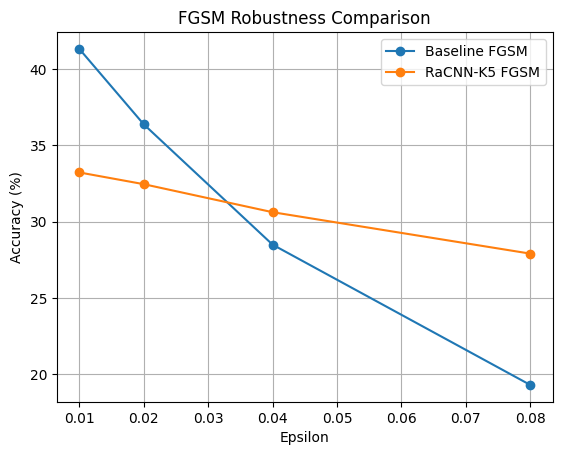

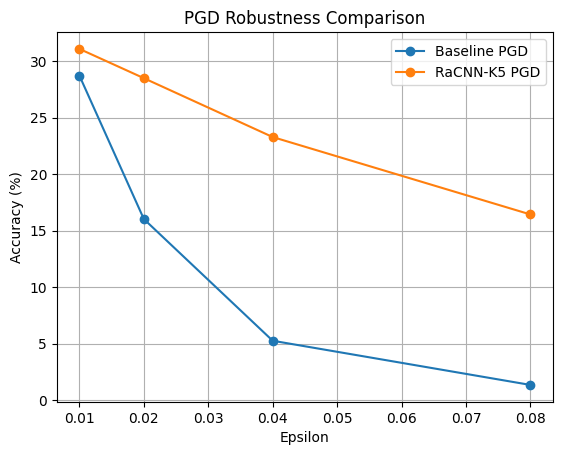

In [89]:
import matplotlib.pyplot as plt

# Results you provided
eps_list = [0.01, 0.02, 0.04, 0.08]

baseline_fgsm = [41.34, 36.39, 28.49, 19.28]
baseline_pgd  = [28.71, 16.02,  5.25,  1.34]

racnn_fgsm = [33.23, 32.46, 30.62, 27.90]
racnn_pgd  = [31.08, 28.49, 23.28, 16.43]

# ---- FGSM Plot ----
plt.figure()
plt.plot(eps_list, baseline_fgsm, marker='o', label="Baseline FGSM")
plt.plot(eps_list, racnn_fgsm, marker='o', label="RaCNN-K5 FGSM")
plt.title("FGSM Robustness Comparison")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

# ---- PGD Plot ----
plt.figure()
plt.plot(eps_list, baseline_pgd, marker='o', label="Baseline PGD")
plt.plot(eps_list, racnn_pgd, marker='o', label="RaCNN-K5 PGD")
plt.title("PGD Robustness Comparison")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()


In [105]:
! pip install foolbox==3.3.3

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------------- -------------- 1.0/1.7 MB 10.1 MB/s eta 0:00:01
   ------------------------- -------------- 1.0/1.7 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 3.0 MB/s eta 0:00:00
  Attempting uninstall: foolbox
    Found existing installation: foolbox 3.3.4
    Uninstalling foolbox-3.3.4:
      Successfully uninstalled foolbox-3.3.4


COMPLETE RACNN EVALUATION

1️⃣ CLEAN ACCURACY
----------------------------------------------------------------------


Baseline Clean: 100%|██████████| 40/40 [00:09<00:00,  4.02it/s]


✅ Baseline Clean: 87.53%


RaCNN Clean: 100%|██████████| 40/40 [00:21<00:00,  1.90it/s]


✅ RaCNN Clean: 83.31%

2️⃣ ADVERSARIAL ROBUSTNESS (L2 PGD)
----------------------------------------------------------------------

Baseline | norm_eps=1.0e-05 → L2=1.0516


  Robust Acc: 15.92%

Baseline | norm_eps=2.0e-05 → L2=1.4872


  Robust Acc: 4.62%

Baseline | norm_eps=8.0e-05 → L2=2.9745


  Robust Acc: 0.01%

Baseline | norm_eps=1.0e-04 → L2=3.3255


  Robust Acc: 0.00%

Baseline | norm_eps=2.0e-04 → L2=4.7030


  Robust Acc: 0.00%

Baseline | norm_eps=4.0e-04 → L2=6.6511


  Robust Acc: 0.00%

RaCNN | norm_eps=1.0e-05 → L2=1.0516


  Robust Acc: 70.12%

RaCNN | norm_eps=2.0e-05 → L2=1.4872


  Robust Acc: 65.32%

RaCNN | norm_eps=8.0e-05 → L2=2.9745


  Robust Acc: 49.54%

RaCNN | norm_eps=1.0e-04 → L2=3.3255


  Robust Acc: 47.10%

RaCNN | norm_eps=2.0e-04 → L2=4.7030


  Robust Acc: 35.55%

RaCNN | norm_eps=4.0e-04 → L2=6.6511


  Robust Acc: 22.74%

3️⃣ PLOTTING RESULTS
----------------------------------------------------------------------


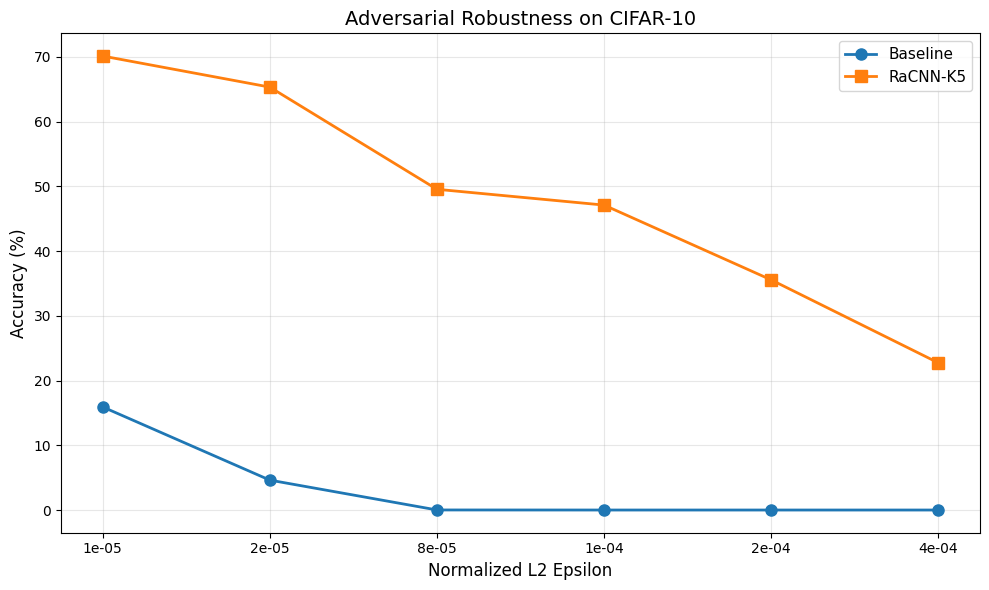


4️⃣ RESULTS SUMMARY
Epsilon      Baseline        RaCNN           Improvement    
----------------------------------------------------------------------
Clean         87.53%          83.31%          -4.22%
1e-05         15.92%          70.12%         +54.20%
2e-05          4.62%          65.32%         +60.70%
8e-05          0.01%          49.54%         +49.53%
1e-04          0.00%          47.10%         +47.10%
2e-04          0.00%          35.55%         +35.55%
4e-04          0.00%          22.74%         +22.74%


In [128]:
import foolbox as fb

def setup_foolbox_models(baseline_model, racnn_model, device="cuda"):
    """
    ✅ FIXED: Correct Foolbox setup
    
    CRITICAL: Your data is ALREADY normalized, so don't normalize again!
    """
    baseline_model.eval()
    racnn_model.eval()
    
    # ✅ CORRECT: No preprocessing (data is already normalized)
    baseline_fmodel = fb.PyTorchModel(
        baseline_model,
        bounds=(-3, 3),  # Approximate bounds for normalized CIFAR-10
        device=device
    )
    
    racnn_fmodel = fb.PyTorchModel(
        racnn_model,
        bounds=(-3, 3),
        device=device
    )
    
    return baseline_fmodel, racnn_fmodel


def eval_clean_accuracy(model_name, fmodel, loader, device="cuda"):
    """Evaluate clean accuracy"""
    correct = total = 0
    
    for x, y in tqdm(loader, desc=f"{model_name} Clean"):
        x, y = x.to(device), y.to(device)
        preds = fmodel(x).argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    
    acc = 100 * correct / total
    print(f"✅ {model_name} Clean: {acc:.2f}%")
    return acc


def eval_robustness(model_name, fmodel, loader, 
                    eps_values=[1e-5, 2e-5, 8e-5, 1e-4, 2e-4, 4e-4],
                    device="cuda"):
    """
    ✅ FIXED: Correct robustness evaluation
    
    Paper uses NORMALIZED L2 distance:
    L2_norm² = ||x - x_adv||² / (dim(x) * (max - min)²)
    """
    results = {}
    DIM = 3 * 32 * 32  # 3072
    
    # For normalized data, the range is approximately (-3, 3) = 6
    VALUE_RANGE = 6.0
    
    attack = fb.attacks.L2ProjectedGradientDescentAttack(
        steps=40,
        rel_stepsize=0.025
    )
    
    for norm_eps in eps_values:
        # Convert normalized eps to actual L2 epsilon
        # norm_eps = L2² / (dim * range²)
        # L2 = sqrt(norm_eps * dim * range²)
        actual_eps = np.sqrt(norm_eps * DIM * VALUE_RANGE**2)
        
        print(f"\n{model_name} | norm_eps={norm_eps:.1e} → L2={actual_eps:.4f}")
        
        correct = total = 0
        
        for x, y in tqdm(loader, desc=f"eps={norm_eps:.1e}", leave=False):
            x, y = x.to(device), y.to(device)
            
            _, clipped, _ = attack(fmodel, x, y, epsilons=[actual_eps])
            
            pert = clipped[0]
            if not torch.is_tensor(pert):
                pert = torch.from_numpy(pert)
            adv = pert.to(device)

            preds = fmodel(adv).argmax(1)
            
            correct += (preds == y).sum().item()
            total += y.size(0)
        
        acc = 100 * correct / total
        results[norm_eps] = acc
        print(f"  Robust Acc: {acc:.2f}%")
    
    return results


# ============================================================================
# 7. COMPLETE EVALUATION SCRIPT
# ============================================================================

def complete_evaluation(baseline_model, racnn_model, test_loader, device="cuda"):
    """Run complete evaluation"""
    
    print("="*70)
    print("COMPLETE RACNN EVALUATION")
    print("="*70)
    
    # Setup Foolbox models
    baseline_fmodel, racnn_fmodel = setup_foolbox_models(
        baseline_model, racnn_model, device
    )
    
    # 1. Clean Accuracy
    print("\n1️⃣ CLEAN ACCURACY")
    print("-"*70)
    clean_baseline = eval_clean_accuracy("Baseline", baseline_fmodel, test_loader, device)
    clean_racnn = eval_clean_accuracy("RaCNN", racnn_fmodel, test_loader, device)
    
    # 2. Robustness Evaluation
    print("\n2️⃣ ADVERSARIAL ROBUSTNESS (L2 PGD)")
    print("-"*70)
    
    eps_values = [1e-5, 2e-5, 8e-5, 1e-4, 2e-4, 4e-4]
    
    robust_baseline = eval_robustness("Baseline", baseline_fmodel, test_loader, 
                                     eps_values, device)
    robust_racnn = eval_robustness("RaCNN", racnn_fmodel, test_loader,
                                   eps_values, device)
    
    # 3. Plot Results
    print("\n3️⃣ PLOTTING RESULTS")
    print("-"*70)
    
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    eps_labels = [f"{eps:.0e}" for eps in eps_values]
    x_pos = np.arange(len(eps_values))
    
    ax.plot(x_pos, [robust_baseline[eps] for eps in eps_values], 
            'o-', label='Baseline', linewidth=2, markersize=8)
    ax.plot(x_pos, [robust_racnn[eps] for eps in eps_values],
            's-', label='RaCNN-K5', linewidth=2, markersize=8)
    
    ax.set_xlabel('Normalized L2 Epsilon', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Adversarial Robustness on CIFAR-10', fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(eps_labels)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('racnn_robustness.png', dpi=300)
    plt.show()
    
    # 4. Summary Table
    print("\n4️⃣ RESULTS SUMMARY")
    print("="*70)
    print(f"{'Epsilon':<12} {'Baseline':<15} {'RaCNN':<15} {'Improvement':<15}")
    print("-"*70)
    print(f"{'Clean':<12} {clean_baseline:>6.2f}%{'':<8} {clean_racnn:>6.2f}%{'':<8} "
          f"{clean_racnn-clean_baseline:>+6.2f}%")
    
    for eps in eps_values:
        improvement = robust_racnn[eps] - robust_baseline[eps]
        print(f"{eps:<12.0e} {robust_baseline[eps]:>6.2f}%{'':<8} "
              f"{robust_racnn[eps]:>6.2f}%{'':<8} {improvement:>+6.2f}%")
    
    print("="*70)
    
    return {
        'clean': {'baseline': clean_baseline, 'racnn': clean_racnn},
        'robust': {'baseline': robust_baseline, 'racnn': robust_racnn}
    }


# ============================================================================
# USAGE
# ============================================================================

# After training baseline and RaCNN:

results = complete_evaluation(
    baseline_model=baseline_model,
    racnn_model=racnn_model,
    test_loader=test_loader,
    device="cuda"
)

FGSM (L2) EVALUATION FOR RACNN

1️⃣ CLEAN ACCURACY


Baseline Clean: 100%|██████████| 40/40 [00:09<00:00,  4.24it/s]


✅ Baseline Clean: 87.03%


RaCNN Clean: 100%|██████████| 40/40 [00:21<00:00,  1.88it/s]


✅ RaCNN Clean: 83.39%

2️⃣ FGSM (L2) ROBUSTNESS

Baseline | norm_eps=1.0e-05 → L2=1.0516


  FGSM L2 Robust Acc: 21.56%

Baseline | norm_eps=2.0e-05 → L2=1.4872


  FGSM L2 Robust Acc: 12.12%

Baseline | norm_eps=8.0e-05 → L2=2.9745


  FGSM L2 Robust Acc: 4.64%

Baseline | norm_eps=1.0e-04 → L2=3.3255


  FGSM L2 Robust Acc: 4.32%

Baseline | norm_eps=2.0e-04 → L2=4.7030


  FGSM L2 Robust Acc: 3.71%

Baseline | norm_eps=4.0e-04 → L2=6.6511


  FGSM L2 Robust Acc: 4.24%

RaCNN | norm_eps=1.0e-05 → L2=1.0516


  FGSM L2 Robust Acc: 72.15%

RaCNN | norm_eps=2.0e-05 → L2=1.4872


  FGSM L2 Robust Acc: 69.63%

RaCNN | norm_eps=8.0e-05 → L2=2.9745


  FGSM L2 Robust Acc: 61.80%

RaCNN | norm_eps=1.0e-04 → L2=3.3255


  FGSM L2 Robust Acc: 59.81%

RaCNN | norm_eps=2.0e-04 → L2=4.7030


  FGSM L2 Robust Acc: 51.35%

RaCNN | norm_eps=4.0e-04 → L2=6.6511


  FGSM L2 Robust Acc: 40.84%


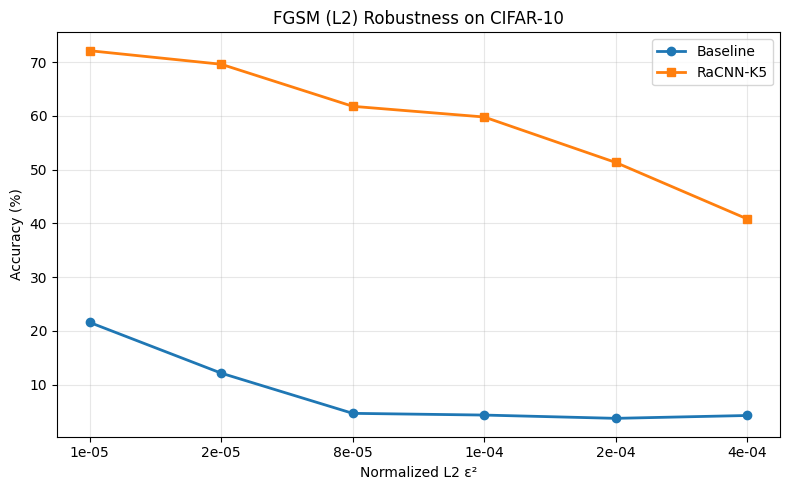


SUMMARY TABLE
Epsilon      Baseline        RaCNN           Δ (RaCNN-B)    
----------------------------------------------------------------------
Clean         87.03%          83.39%          -3.64%
1e-05         21.56%          72.15%         +50.59%
2e-05         12.12%          69.63%         +57.51%
8e-05          4.64%          61.80%         +57.16%
1e-04          4.32%          59.81%         +55.49%
2e-04          3.71%          51.35%         +47.64%
4e-04          4.24%          40.84%         +36.60%


In [21]:
import torch
import numpy as np
import foolbox as fb
from tqdm import tqdm
import matplotlib.pyplot as plt


# ==========================================================
# ✅ Foolbox model setup (no extra preprocessing)
# ==========================================================
def setup_foolbox_models(baseline_model, racnn_model, device="cuda"):
    baseline_model.eval()
    racnn_model.eval()

    baseline_fmodel = fb.PyTorchModel(
        baseline_model,
        bounds=(-3, 3),   # normalized CIFAR-10 input range
        device=device
    )

    racnn_fmodel = fb.PyTorchModel(
        racnn_model,
        bounds=(-3, 3),
        device=device
    )

    return baseline_fmodel, racnn_fmodel


# ==========================================================
# ✅ Clean Accuracy
# ==========================================================
def eval_clean_accuracy(model_name, fmodel, loader, device="cuda"):
    correct = total = 0
    model = fmodel._model  # underlying PyTorch model

    for x, y in tqdm(loader, desc=f"{model_name} Clean"):
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = 100 * correct / total
    print(f"✅ {model_name} Clean: {acc:.2f}%")
    return acc


# ==========================================================
# ✅ FGSM (L2 Fast Gradient Method) Robustness Evaluation
# ==========================================================
def eval_fgsm_l2(model_name, fmodel, loader,
                 eps_values=[1e-5, 2e-5, 8e-5, 1e-4, 2e-4, 4e-4],
                 device="cuda"):
    """
    L2 Fast Gradient Method (FGSM) evaluation
    Equivalent to 1-step L2 PGD with step-size = epsilon
    """
    results = {}
    DIM = 3 * 32 * 32
    VALUE_RANGE = 6.0  # for normalized CIFAR-10

    attack = fb.attacks.L2FastGradientAttack()  # ✅ single-step attack

    for norm_eps in eps_values:
        # Convert normalized eps to actual L2 epsilon
        actual_eps = np.sqrt(norm_eps * DIM * VALUE_RANGE**2)
        print(f"\n{model_name} | norm_eps={norm_eps:.1e} → L2={actual_eps:.4f}")

        correct = total = 0

        for x, y in tqdm(loader, desc=f"FGSM L2 eps={norm_eps:.1e}", leave=False):
            x, y = x.to(device), y.to(device)

            _, clipped, _ = attack(fmodel, x, y, epsilons=[actual_eps])

            adv = clipped[0]
            if not torch.is_tensor(adv):
                adv = torch.from_numpy(adv)
            adv = adv.to(device)

            preds = fmodel._model(adv).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        acc = 100 * correct / total
        results[norm_eps] = acc
        print(f"  FGSM L2 Robust Acc: {acc:.2f}%")

    return results


# ==========================================================
# ✅ Combine Clean + FGSM L2
# ==========================================================
def complete_fgsm_evaluation(baseline_model, racnn_model, test_loader, device="cuda"):
    print("=" * 70)
    print("FGSM (L2) EVALUATION FOR RACNN")
    print("=" * 70)

    baseline_fmodel, racnn_fmodel = setup_foolbox_models(baseline_model, racnn_model, device)

    print("\n1️⃣ CLEAN ACCURACY")
    clean_base = eval_clean_accuracy("Baseline", baseline_fmodel, test_loader, device)
    clean_rac = eval_clean_accuracy("RaCNN", racnn_fmodel, test_loader, device)

    print("\n2️⃣ FGSM (L2) ROBUSTNESS")
    eps_values = [1e-5, 2e-5, 8e-5, 1e-4, 2e-4, 4e-4]
    robust_base = eval_fgsm_l2("Baseline", baseline_fmodel, test_loader, eps_values, device)
    robust_rac = eval_fgsm_l2("RaCNN", racnn_fmodel, test_loader, eps_values, device)

    # Plot results
    eps_labels = [f"{eps:.0e}" for eps in eps_values]
    x = np.arange(len(eps_values))

    plt.figure(figsize=(8, 5))
    plt.plot(x, [robust_base[e] for e in eps_values], 'o-', label='Baseline', linewidth=2)
    plt.plot(x, [robust_rac[e] for e in eps_values], 's-', label='RaCNN-K5', linewidth=2)
    plt.xticks(x, eps_labels)
    plt.xlabel("Normalized L2 ε²")
    plt.ylabel("Accuracy (%)")
    plt.title("FGSM (L2) Robustness on CIFAR-10")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\nSUMMARY TABLE")
    print("=" * 70)
    print(f"{'Epsilon':<12} {'Baseline':<15} {'RaCNN':<15} {'Δ (RaCNN-B)':<15}")
    print("-" * 70)
    print(f"{'Clean':<12} {clean_base:>6.2f}%{'':<8} {clean_rac:>6.2f}%{'':<8} {clean_rac-clean_base:>+6.2f}%")
    for eps in eps_values:
        diff = robust_rac[eps] - robust_base[eps]
        print(f"{eps:<12.0e} {robust_base[eps]:>6.2f}%{'':<8} {robust_rac[eps]:>6.2f}%{'':<8} {diff:>+6.2f}%")
    print("=" * 70)

    return {"clean": {"base": clean_base, "rac": clean_rac},
            "robust": {"base": robust_base, "rac": robust_rac}}


# ==========================================================
# ✅ Usage
# ==========================================================
results_fgsm = complete_fgsm_evaluation(
    baseline_model=baseline_model,
    racnn_model=racnn_model,
    test_loader=test_loader,
    device="cuda"
)


iFGSM (L2) EVALUATION FOR RACNN

1️⃣ CLEAN ACCURACY


Baseline Clean: 100%|██████████| 40/40 [00:09<00:00,  4.01it/s]


✅ Baseline Clean: 87.03%


RaCNN Clean: 100%|██████████| 40/40 [00:18<00:00,  2.12it/s]


✅ RaCNN Clean: 83.39%

2️⃣ iFGSM (L2) ROBUSTNESS

Baseline | norm_eps=1.0e-05 → L2=1.0516


  iFGSM L2 Robust Acc: 4.82%

Baseline | norm_eps=2.0e-05 → L2=1.4872


  iFGSM L2 Robust Acc: 0.59%

Baseline | norm_eps=8.0e-05 → L2=2.9745


  iFGSM L2 Robust Acc: 0.00%

Baseline | norm_eps=1.0e-04 → L2=3.3255


  iFGSM L2 Robust Acc: 0.00%

Baseline | norm_eps=2.0e-04 → L2=4.7030


  iFGSM L2 Robust Acc: 0.00%

Baseline | norm_eps=4.0e-04 → L2=6.6511


  iFGSM L2 Robust Acc: 0.00%

RaCNN | norm_eps=1.0e-05 → L2=1.0516


  iFGSM L2 Robust Acc: 65.29%

RaCNN | norm_eps=2.0e-05 → L2=1.4872


  iFGSM L2 Robust Acc: 58.07%

RaCNN | norm_eps=8.0e-05 → L2=2.9745


  iFGSM L2 Robust Acc: 39.21%

RaCNN | norm_eps=1.0e-04 → L2=3.3255


  iFGSM L2 Robust Acc: 35.76%

RaCNN | norm_eps=2.0e-04 → L2=4.7030


  iFGSM L2 Robust Acc: 26.63%

RaCNN | norm_eps=4.0e-04 → L2=6.6511


  iFGSM L2 Robust Acc: 18.24%


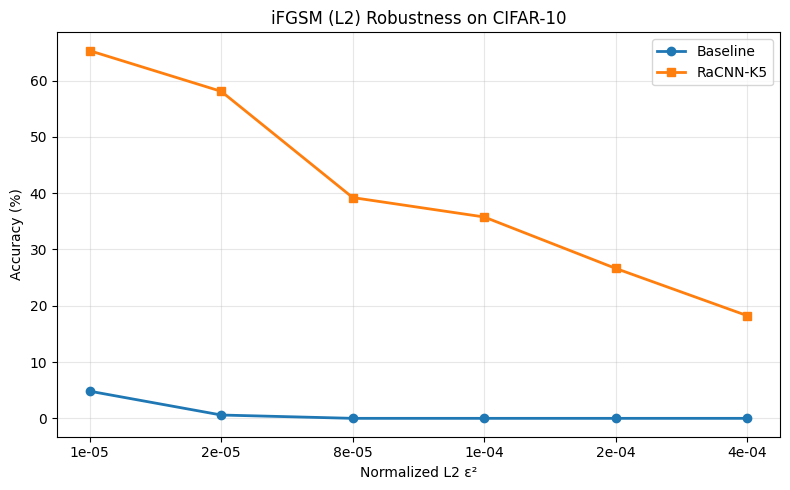


SUMMARY TABLE
Epsilon      Baseline        RaCNN           Δ (RaCNN-B)    
----------------------------------------------------------------------
Clean         87.03%          83.39%          -3.64%
1e-05          4.82%          65.29%         +60.47%
2e-05          0.59%          58.07%         +57.48%
8e-05          0.00%          39.21%         +39.21%
1e-04          0.00%          35.76%         +35.76%
2e-04          0.00%          26.63%         +26.63%
4e-04          0.00%          18.24%         +18.24%


In [22]:
# ==========================================================
# ✅ iFGSM (L2 Basic Iterative Attack) Robustness Evaluation
# ==========================================================
def eval_ifgsm_l2(model_name, fmodel, loader,
                  eps_values=[1e-5, 2e-5, 8e-5, 1e-4, 2e-4, 4e-4],
                  steps=10,
                  device="cuda"):
    """
    L2 Basic Iterative Method (multi-step FGSM)
    Equivalent to iterative L2 PGD without random starts
    """
    results = {}
    DIM = 3 * 32 * 32
    VALUE_RANGE = 6.0  # for normalized CIFAR-10

    attack = fb.attacks.L2BasicIterativeAttack(steps=steps)

    for norm_eps in eps_values:
        actual_eps = np.sqrt(norm_eps * DIM * VALUE_RANGE**2)
        print(f"\n{model_name} | norm_eps={norm_eps:.1e} → L2={actual_eps:.4f}")

        correct = total = 0

        for x, y in tqdm(loader, desc=f"iFGSM L2 eps={norm_eps:.1e}", leave=False):
            x, y = x.to(device), y.to(device)

            _, clipped, _ = attack(fmodel, x, y, epsilons=[actual_eps])

            adv = clipped[0]
            if not torch.is_tensor(adv):
                adv = torch.from_numpy(adv)
            adv = adv.to(device)

            preds = fmodel._model(adv).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        acc = 100 * correct / total
        results[norm_eps] = acc
        print(f"  iFGSM L2 Robust Acc: {acc:.2f}%")

    return results


# ==========================================================
# ✅ Combine Clean + iFGSM L2
# ==========================================================
def complete_ifgsm_evaluation(baseline_model, racnn_model, test_loader, device="cuda"):
    print("=" * 70)
    print("iFGSM (L2) EVALUATION FOR RACNN")
    print("=" * 70)

    baseline_fmodel, racnn_fmodel = setup_foolbox_models(baseline_model, racnn_model, device)

    print("\n1️⃣ CLEAN ACCURACY")
    clean_base = eval_clean_accuracy("Baseline", baseline_fmodel, test_loader, device)
    clean_rac = eval_clean_accuracy("RaCNN", racnn_fmodel, test_loader, device)

    print("\n2️⃣ iFGSM (L2) ROBUSTNESS")
    eps_values = [1e-5, 2e-5, 8e-5, 1e-4, 2e-4, 4e-4]
    robust_base = eval_ifgsm_l2("Baseline", baseline_fmodel, test_loader, eps_values, steps=10, device=device)
    robust_rac = eval_ifgsm_l2("RaCNN", racnn_fmodel, test_loader, eps_values, steps=10, device=device)

    # Plot results
    eps_labels = [f"{eps:.0e}" for eps in eps_values]
    x = np.arange(len(eps_values))

    plt.figure(figsize=(8, 5))
    plt.plot(x, [robust_base[e] for e in eps_values], 'o-', label='Baseline', linewidth=2)
    plt.plot(x, [robust_rac[e] for e in eps_values], 's-', label='RaCNN-K5', linewidth=2)
    plt.xticks(x, eps_labels)
    plt.xlabel("Normalized L2 ε²")
    plt.ylabel("Accuracy (%)")
    plt.title("iFGSM (L2) Robustness on CIFAR-10")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\nSUMMARY TABLE")
    print("=" * 70)
    print(f"{'Epsilon':<12} {'Baseline':<15} {'RaCNN':<15} {'Δ (RaCNN-B)':<15}")
    print("-" * 70)
    print(f"{'Clean':<12} {clean_base:>6.2f}%{'':<8} {clean_rac:>6.2f}%{'':<8} {clean_rac-clean_base:>+6.2f}%")
    for eps in eps_values:
        diff = robust_rac[eps] - robust_base[eps]
        print(f"{eps:<12.0e} {robust_base[eps]:>6.2f}%{'':<8} {robust_rac[eps]:>6.2f}%{'':<8} {diff:>+6.2f}%")
    print("=" * 70)

    return {"clean": {"base": clean_base, "rac": clean_rac},
            "robust": {"base": robust_base, "rac": robust_rac}}


# ==========================================================
# ✅ Usage
# ==========================================================
results_ifgsm = complete_ifgsm_evaluation(
    baseline_model=baseline_model,
    racnn_model=racnn_model,
    test_loader=test_loader,
    device="cuda"
)


DeepFool (L2) EVALUATION FOR RACNN

1️⃣ CLEAN ACCURACY


Baseline Clean: 100%|██████████| 40/40 [00:09<00:00,  4.14it/s]


✅ Baseline Clean: 87.03%


RaCNN Clean: 100%|██████████| 40/40 [00:19<00:00,  2.07it/s]


✅ RaCNN Clean: 83.39%

2️⃣ DEEPFOOL (L2) ROBUSTNESS

Baseline | norm_eps=1.0e-05 → L2=1.0516


  DeepFool L2 Robust Acc: 10.86%

Baseline | norm_eps=2.0e-05 → L2=1.4872


  DeepFool L2 Robust Acc: 2.84%

Baseline | norm_eps=8.0e-05 → L2=2.9745


  DeepFool L2 Robust Acc: 0.00%

Baseline | norm_eps=1.0e-04 → L2=3.3255


  DeepFool L2 Robust Acc: 0.00%

Baseline | norm_eps=2.0e-04 → L2=4.7030


  DeepFool L2 Robust Acc: 0.00%

Baseline | norm_eps=4.0e-04 → L2=6.6511


  DeepFool L2 Robust Acc: 0.00%

RaCNN | norm_eps=1.0e-05 → L2=1.0516


  DeepFool L2 Robust Acc: 69.16%

RaCNN | norm_eps=2.0e-05 → L2=1.4872


  DeepFool L2 Robust Acc: 64.36%

RaCNN | norm_eps=8.0e-05 → L2=2.9745


  DeepFool L2 Robust Acc: 49.28%

RaCNN | norm_eps=1.0e-04 → L2=3.3255


  DeepFool L2 Robust Acc: 45.42%

RaCNN | norm_eps=2.0e-04 → L2=4.7030


  DeepFool L2 Robust Acc: 32.49%

RaCNN | norm_eps=4.0e-04 → L2=6.6511


  DeepFool L2 Robust Acc: 18.87%


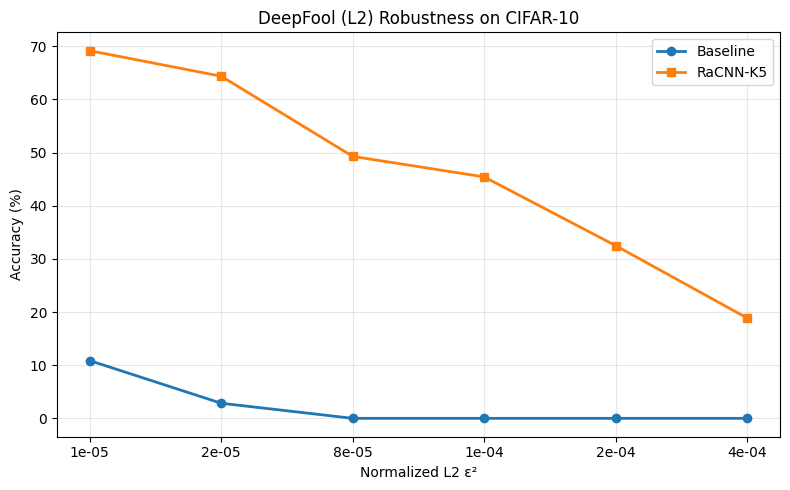


SUMMARY TABLE
Epsilon      Baseline        RaCNN           Δ (RaCNN-B)    
----------------------------------------------------------------------
Clean         87.03%          83.39%          -3.64%
1e-05         10.86%          69.16%         +58.30%
2e-05          2.84%          64.36%         +61.52%
8e-05          0.00%          49.28%         +49.28%
1e-04          0.00%          45.42%         +45.42%
2e-04          0.00%          32.49%         +32.49%
4e-04          0.00%          18.87%         +18.87%


In [23]:
def eval_deepfool_l2(model_name, fmodel, loader,
                     eps_values=[1e-5, 2e-5, 8e-5, 1e-4, 2e-4, 4e-4],
                     steps=50,
                     device="cuda"):
    """
    DeepFool (L2) — an iterative attack that finds minimal perturbations.
    We threshold the perturbation by given L2 radius for fair comparison.
    """
    results = {}
    DIM = 3 * 32 * 32
    VALUE_RANGE = 6.0  # normalized CIFAR-10 range

    attack = fb.attacks.L2DeepFoolAttack(steps=steps)

    for norm_eps in eps_values:
        actual_eps = np.sqrt(norm_eps * DIM * VALUE_RANGE**2)
        print(f"\n{model_name} | norm_eps={norm_eps:.1e} → L2={actual_eps:.4f}")

        correct = total = 0

        for x, y in tqdm(loader, desc=f"DeepFool L2 eps={norm_eps:.1e}", leave=False):
            x, y = x.to(device), y.to(device)

            _, clipped, _ = attack(fmodel, x, y, epsilons=[actual_eps])

            adv = clipped[0]
            if not torch.is_tensor(adv):
                adv = torch.from_numpy(adv)
            adv = adv.to(device)

            preds = fmodel._model(adv).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        acc = 100 * correct / total
        results[norm_eps] = acc
        print(f"  DeepFool L2 Robust Acc: {acc:.2f}%")

    return results


# ==========================================================
# ✅ Combine Clean + DeepFool L2
# ==========================================================
def complete_deepfool_evaluation(baseline_model, racnn_model, test_loader, device="cuda"):
    print("=" * 70)
    print("DeepFool (L2) EVALUATION FOR RACNN")
    print("=" * 70)

    baseline_fmodel, racnn_fmodel = setup_foolbox_models(baseline_model, racnn_model, device)

    print("\n1️⃣ CLEAN ACCURACY")
    clean_base = eval_clean_accuracy("Baseline", baseline_fmodel, test_loader, device)
    clean_rac = eval_clean_accuracy("RaCNN", racnn_fmodel, test_loader, device)

    print("\n2️⃣ DEEPFOOL (L2) ROBUSTNESS")
    eps_values = [1e-5, 2e-5, 8e-5, 1e-4, 2e-4, 4e-4]
    robust_base = eval_deepfool_l2("Baseline", baseline_fmodel, test_loader, eps_values, steps=50, device=device)
    robust_rac = eval_deepfool_l2("RaCNN", racnn_fmodel, test_loader, eps_values, steps=50, device=device)

    # Plot results
    eps_labels = [f"{eps:.0e}" for eps in eps_values]
    x = np.arange(len(eps_values))

    plt.figure(figsize=(8, 5))
    plt.plot(x, [robust_base[e] for e in eps_values], 'o-', label='Baseline', linewidth=2)
    plt.plot(x, [robust_rac[e] for e in eps_values], 's-', label='RaCNN-K5', linewidth=2)
    plt.xticks(x, eps_labels)
    plt.xlabel("Normalized L2 ε²")
    plt.ylabel("Accuracy (%)")
    plt.title("DeepFool (L2) Robustness on CIFAR-10")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\nSUMMARY TABLE")
    print("=" * 70)
    print(f"{'Epsilon':<12} {'Baseline':<15} {'RaCNN':<15} {'Δ (RaCNN-B)':<15}")
    print("-" * 70)
    print(f"{'Clean':<12} {clean_base:>6.2f}%{'':<8} {clean_rac:>6.2f}%{'':<8} {clean_rac-clean_base:>+6.2f}%")
    for eps in eps_values:
        diff = robust_rac[eps] - robust_base[eps]
        print(f"{eps:<12.0e} {robust_base[eps]:>6.2f}%{'':<8} {robust_rac[eps]:>6.2f}%{'':<8} {diff:>+6.2f}%")
    print("=" * 70)

    return {"clean": {"base": clean_base, "rac": clean_rac},
            "robust": {"base": robust_base, "rac": robust_rac}}


# ==========================================================
# ✅ Usage
# ==========================================================
results_deepfool = complete_deepfool_evaluation(
    baseline_model=baseline_model,
    racnn_model=racnn_model,
    test_loader=test_loader,
    device="cuda"
)